In [1]:
import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
import torch
import matplotlib.pyplot as plt

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# test notebook for pretrained cnn feature extraction

In [2]:
from typing import Callable, Iterable, Optional, Union
from scipy.ndimage import zoom
import datetime as dt


PRETRAINED_OUTPUT_DIMS = 1_000
NWP_VARIABLE_NUM = 17

def _downsample_and_process_for_pretrained_input(nwp_data_time_slice: xr.DataArray) -> torch.Tensor:
    nwp_data_time_slice = nwp_data_time_slice.as_numpy().values
    nwp_data_time_slice = np.nan_to_num(nwp_data_time_slice)
    nwp_data_time_slice = np.tile(zoom(nwp_data_time_slice, (1, 64/704, 64/548), order=1), (3, 1, 1, 1)).reshape(17, 3, 64, 64)
    return torch.from_numpy(nwp_data_time_slice)

def _downsample_pretrained_output(model_output: torch.Tensor) -> np.ndarray:
    with torch.no_grad():
        output = torch.softmax(model_output, 1)
        output = np.split(output, range(200, PRETRAINED_OUTPUT_DIMS, 200), axis=1)
        dsampled_output = torch.concat([torch.linalg.norm(x, axis=1).reshape(1, NWP_VARIABLE_NUM) for x in output]).T
        assert dsampled_output.shape == (NWP_VARIABLE_NUM, 5)
        return dsampled_output.numpy().flatten()


@functional_datapipe("process_nwp_pretrained")
class ProcessNWPPretrainedIterDataPipe(IterDataPipe):
    def __init__(self, base_nwp_datapipe: IterDataPipe, step: int, pretrained_model: Callable[[torch.Tensor], torch.Tensor], interpolate: bool = False, interpolation_timepoints = Optional[Iterable[Union[dt.datetime, np.datetime64]]]) -> None:
        if interpolate:
            assert interpolation_timepoints is not None, "Must provide points for interpolation."
        self.source_datapipe = base_nwp_datapipe
        self.step = step
        self.pretrained_model = pretrained_model
        self.interpolation_timepoints = interpolation_timepoints
    def __iter__(self):
        for nwp in self.source_datapipe:
            nwp = nwp.isel(step=self.step)  # select the horizon we want
            nwp.interp(init_time_utc=self.interpolation_timepoints, method="cubic")  # interpolate to perscribed points
            for time, nwp_by_init_time in nwp.groupby("init_time_utc"):
                # at each time point, pass the nwp data to pretrained model
                data = _downsample_and_process_for_pretrained_input(nwp_by_init_time)
                data = self.pretrained_model(data)
                data = _downsample_pretrained_output(data)
                yield (time, data)

In [4]:
from torchvision.models import resnet101
from ocf_datapipes.load.nwp.nwp import OpenNWPIterDataPipe
import pandas as pd

nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
base_nwp_dpipe =  OpenNWPIterDataPipe(nwp_path)
model = resnet101(pretrained=True)
process_nwp = ProcessNWPPretrainedIterDataPipe(base_nwp_dpipe, 4, model, interpolate=True, interpolation_timepoints=pd.date_range("2020-01-01 00:00", "2022-01-01 00:00", freq="0.5H"))

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
output_size = 5*17
obs = 1_000
results = []

count = 0
for x in process_nwp:
    results.append(x)
    count +=1
    
    if count == 1_000:
        break

In [15]:
results

[(numpy.datetime64('2020-01-01T00:00:00.000000000'),
  array([1.67538300e-01, 3.08745682e-01, 2.89069000e-03, 2.38098484e-03,
         8.51276983e-03, 3.99928467e-05, 1.27211772e-02, 9.16136801e-01,
         1.62498429e-02, 3.88147198e-02, 9.43456497e-03, 2.62956936e-02,
         8.40119347e-02, 1.34962067e-01, 3.65997329e-02, 1.19008645e-02,
         2.44912179e-03, 3.22482251e-02, 2.45866373e-01, 1.46334887e-01,
         4.13943827e-01, 2.14200228e-01, 1.45370672e-02, 2.20285840e-02,
         1.53110707e-02, 4.58092615e-03, 3.27864569e-03, 5.53700440e-02,
         3.44276249e-01, 1.35193303e-01, 4.04100865e-02, 5.40920794e-02,
         3.28413844e-02, 4.25724834e-02, 3.89460064e-02, 6.08137883e-02,
         3.66210610e-01, 1.53056374e-02, 9.67598986e-03, 3.66750136e-02,
         3.85019407e-02, 2.48547923e-02, 5.84433153e-02, 2.50712391e-02,
         3.81160714e-02, 4.54318635e-02, 7.83828873e-05, 2.51499772e-01,
         9.58697870e-02, 4.21592444e-01, 4.73523542e-05, 4.58744034e-05

In [ ]:
import pickle 

with open('/home/tom/local_data/pretrained_nwp_processing_step_0.pkl', 'rb') as f:
    results = pickle.load(f)

In [1]:
import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
import torch
import pickle
from torchvision.models import resnet101
from ocf_datapipes.load.nwp.nwp import OpenNWPIterDataPipe

from typing import Callable, Iterable, Optional, Union
from scipy.ndimage import zoom
import datetime as dt


PRETRAINED_OUTPUT_DIMS = 1_000
NWP_VARIABLE_NUM = 17
NWP_FPATH = (
    "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
)
GSP_FPATH = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
NUM_OBS = 35_000

BATCH_SIZE = 64


def _downsample_and_process_for_pretrained_input(
    nwp_data_time_slice: xr.DataArray,
) -> torch.Tensor:
    nwp_data_time_slice = nwp_data_time_slice.as_numpy().values
    nwp_data_time_slice = np.nan_to_num(nwp_data_time_slice)
    nwp_data_time_slice = np.tile(
        zoom(nwp_data_time_slice, (1, 64 / 704, 64 / 548), order=1), (3, 1, 1, 1)
    ).reshape(17, 3, 64, 64)
    return torch.from_numpy(nwp_data_time_slice)


def _downsample_pretrained_output(model_output: torch.Tensor) -> np.ndarray:
    with torch.no_grad():
        output = torch.softmax(model_output, 1)
        output = np.split(output, range(200, PRETRAINED_OUTPUT_DIMS, 200), axis=1)
        dsampled_output = torch.concat(
            [torch.linalg.norm(x, axis=1).reshape(1, NWP_VARIABLE_NUM) for x in output]
        ).T
        assert dsampled_output.shape == (NWP_VARIABLE_NUM, 5)
        return dsampled_output.numpy().flatten()


@functional_datapipe("process_nwp_pretrained")
class ProcessNWPPretrainedIterDataPipe(IterDataPipe):
    def __init__(
        self,
        base_nwp_datapipe: IterDataPipe,
        step: int,
        pretrained_model: Callable[[torch.Tensor], torch.Tensor],
        interpolate: bool = False,
        interpolation_timepoints=Optional[Iterable[Union[dt.datetime, np.datetime64]]],
    ) -> None:
        if interpolate:
            assert (
                interpolation_timepoints is not None
            ), "Must provide points for interpolation."
        self.source_datapipe = base_nwp_datapipe
        self.step = step
        self.pretrained_model = pretrained_model
        self.interpolation_timepoints = interpolation_timepoints

    def __iter__(self):
        for nwp in self.source_datapipe:
            nwp = nwp.isel(step=self.step)  # select the horizon we want
            nwp.interp(
                init_time_utc=self.interpolation_timepoints, method="linear"
            )  # interpolate to perscribed points
            for batch_idx in range(BATCH_SIZE, int(len(nwp.coords["init_time"])), BATCH_SIZE):
                # at each time point, pass the nwp data to pretrained model
                data = _downsample_and_process_for_pretrained_input(nwp.isel(init_time=slice(batch_idx - BATCH_SIZE, batch_idx)))
                data = self.pretrained_model(data)
                data = _downsample_pretrained_output(data)
                yield (time, data)



/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [7]:
BATCH_SIZE = 5

nwp = xr.open_zarr(NWP_FPATH)
gsp = xr.open_zarr("gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr")

evaluation_timeseries = (
    gsp.coords["datetime_gmt"]
    .where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0])
        & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]),
        drop=True,
    )
    .values
)

nwp = nwp.chunk(chunks={"init_time": BATCH_SIZE, "variable": 1, "step": 1})

for batch_idx in range(BATCH_SIZE, int(len(nwp.coords["init_time"])), BATCH_SIZE):
                # at each time point, pass the nwp data to pretrained model
    break

from math import floor

subset = nwp.isel(init_time=slice(batch_idx - BATCH_SIZE, batch_idx)).coarsen(dim={
    "x": floor(548 / 64),
    "y": floor(704 / 64),
    },
    boundary="trim").mean().to_array().to_numpy()

_x = subset.reshape(17*BATCH_SIZE*37, 64, 68)
_x = np.tile(_x, (3, 1, 1, 1)).reshape(17*BATCH_SIZE*37, 3, 64, 68)

In [8]:
subset.shape

(1, 17, 5, 37, 64, 68)

In [9]:
import torch
from torchvision.models import resnet101

model = resnet101(pretrained=True)
tscript_model = torch.jit.script(model)

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
with torch.no_grad():
        output = model(torch.from_numpy(np.nan_to_num(_x)))
        output = torch.softmax(output, 1)
        output = np.split(output, range(200, PRETRAINED_OUTPUT_DIMS, 200), axis=1)
        n = torch.linalg.norm(output[0], axis=1).shape[0]
        output = torch.concat(
            [torch.linalg.norm(x, axis=1).reshape(1, n) for x in output]).T
        
        # assert dsampled_output.shape == (NWP_VARIABLE_NUM, 5)
        # return dsampled_output.numpy().flatten()

In [ ]:
output.shape

torch.Size([18870, 5])

In [ ]:
test = output.reshape(17, BATCH_SIZE, 37, 5).numpy()

In [ ]:
test.size * test.itemsize

377400

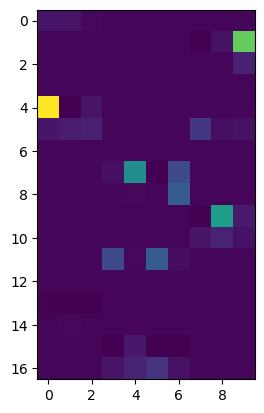

In [16]:
import matplotlib.pyplot as plt
plt.imshow(test[:, :, 22, 4])

In [7]:
import matplotlib.pyplot as plt

plt.plot(torch.linalg.norm(output[0], axis=1))

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [40]:
n = torch.linalg.norm(output[0], axis=1).shape[0]

In [42]:
dsampled_output = torch.concat(
            [torch.linalg.norm(x, axis=1).reshape(1, n) for x in output])

In [52]:
final = dsampled_output.T.reshape(17, 37, 5)

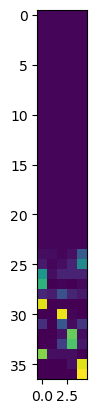

In [101]:
plt.imshow(final[9, :])

In [96]:
final.shape

torch.Size([17, 37, 5])

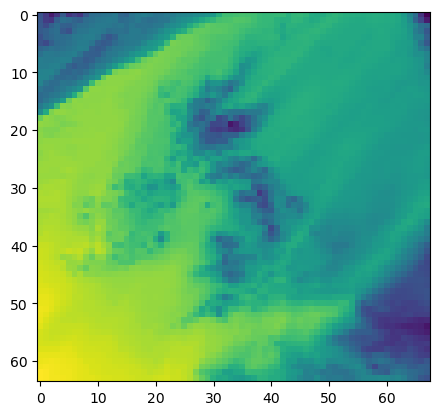

In [105]:
plt.imshow(subset[0, 9, 0, 34, :, :])

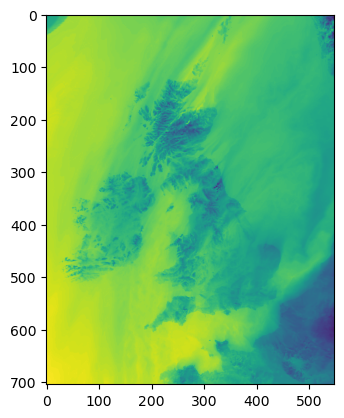

In [98]:
plt.imshow(nwp.isel(variable=9, step=26, init_time=0).to_array().values.reshape(704, 548))

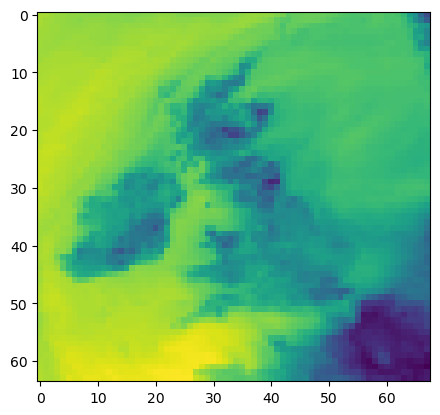

In [99]:
plt.imshow(subset[0, 9, 0, 5, :, :])

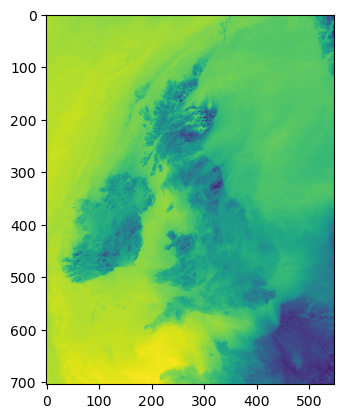

In [100]:
plt.imshow(nwp.isel(variable=9, step=5, init_time=0).to_array().values.reshape(704, 548))

In [82]:
subset.shape

(1, 17, 1, 37, 64, 68)

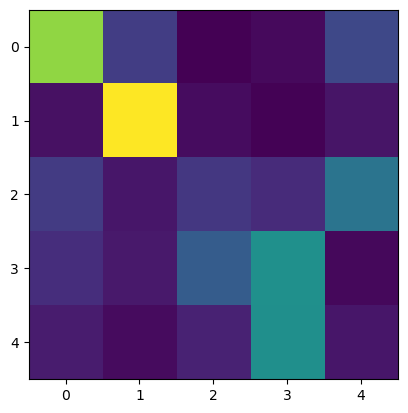

In [47]:
plt.imshow(dsampled_output.T[:5])

In [8]:
_x = subset.as_numpy().values

AttributeError: 'DataArrayCoarsen' object has no attribute 'as_numpy'

In [ ]:
_x.shape

In [9]:
_x = _x.reshape((17*12, 37, 704, 548))

In [10]:
out = zoom(_x, (1, 1, 64/704, 64/548))
out.shape

In [ ]:
np.tile(zoom(
    _x, (1,1, 64/704, 64/548), order=1)
))

In [8]:
for i in range(10):
    _ = subset.isel(init_time=i).as_numpy().values

KeyboardInterrupt: 

In [ ]:
_x = np.nan_to_num(_x)